# Image Matching 

**Loading Libraries**

In [1]:
import os
import math
import time
import sys
import PIL
import random
import cv2

In [3]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Skimage
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

In [5]:
# Sklearn
from sklearn.preprocessing import normalize

# Torch Librarues



In [6]:
# Multiple print statments in a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Adjust the Display options for number of rows and columns 
pd.set_option("display.max_columns", 500)
pd.set_option("display.min_rows", 500)

# Supress the warnings
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Check the verions of torch

print(f'Pytorch Version : {cv2.__version__}')

Pytorch Version : 4.6.0


**Define the dataset path where the images are stored**

In [9]:
DF_Path = os.getcwd()
DF_Path

'/Users/rishabhshukla/Desktop/indicent/CV'

**Load the two images**

In [11]:
raw_img_1 = cv2.imread(DF_Path + '/building_1.jpeg')

raw_img_2 = cv2.imread(DF_Path + '/building_2.jpeg')

**Convert the images into RGB (compataible for CV2)**

In [12]:
img_1 = cv2.cvtColor(raw_img_1, cv2.COLOR_BGR2RGB)
img_2 = cv2.cvtColor(raw_img_2, cv2.COLOR_BGR2RGB)

**Plot the images**

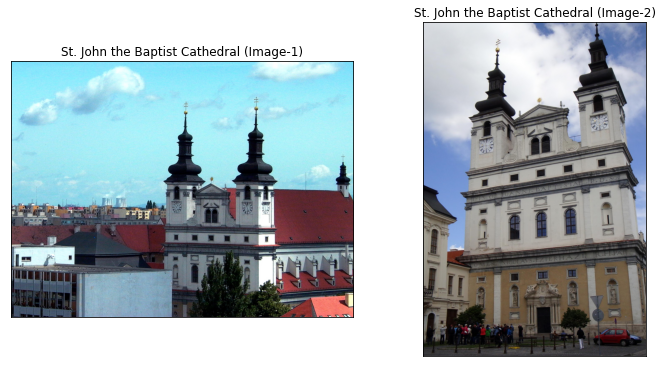

In [13]:
plt.figure(figsize=(10,10))

plt.subplot(221),
plt.imshow(img_1)
plt.title('St. John the Baptist Cathedral (Image-1)'), 
plt.xticks([]), plt.yticks([])

plt.subplot(222),
plt.imshow(img_2)
plt.title('St. John the Baptist Cathedral (Image-2)'), 
plt.xticks([]), plt.yticks([])

plt.tight_layout()
plt.show();

### HOG Featrues on Images

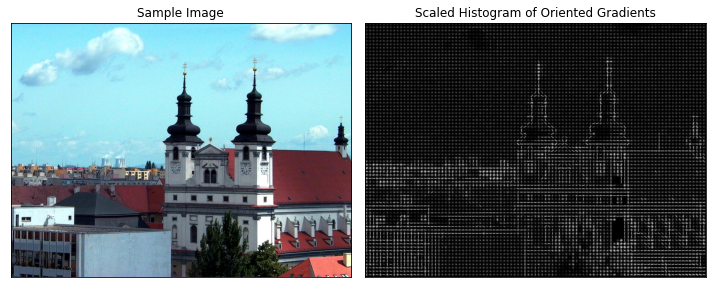

In [14]:
fd, hog_image = hog(img_1, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=True)

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))


plt.figure(figsize=(10,10))
plt.subplot(121),
plt.imshow(img_1)
plt.title(f'Sample Image'), 
plt.xticks([]), plt.yticks([])

plt.subplot(122),
plt.imshow(hog_image_rescaled,cmap=plt.cm.gray)
plt.title(f'Scaled Histogram of Oriented Gradients'), 
plt.xticks([]), plt.yticks([])

plt.tight_layout()
plt.show();

### ORB Interest Points

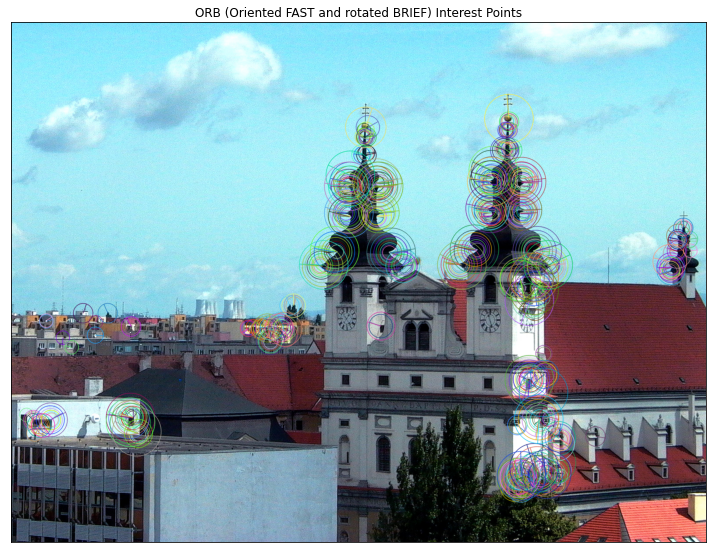

In [15]:
orb = cv2.ORB_create()

key_points, description = orb.detectAndCompute(img_1, None)

img_1_keypoints = cv2.drawKeypoints(img_1,
                                    key_points, 
                                    img_1, 
                                    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10,10))
plt.title('ORB (Oriented FAST and rotated BRIEF) Interest Points')
plt.imshow(img_1_keypoints)
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show();

### SIFT Interest Points

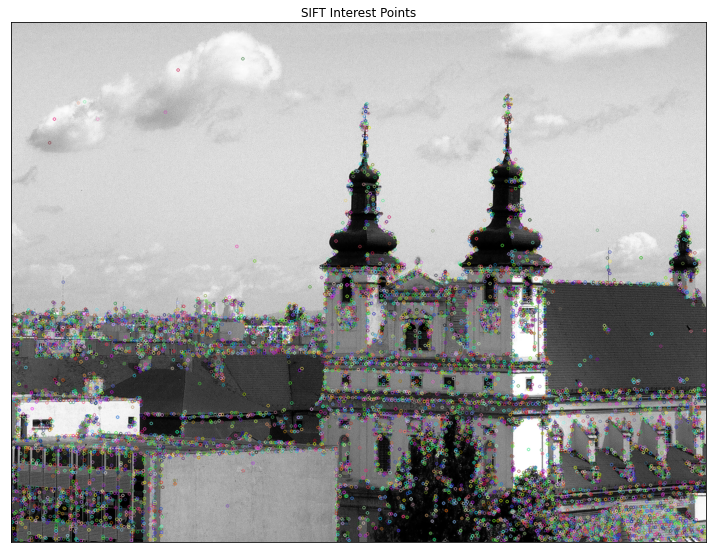

In [16]:
# convert the image grayscale
img_1_gray = cv2.cvtColor(raw_img_1, cv2.COLOR_BGR2GRAY)

# create SIFT feature extractor
sift = cv2.SIFT_create()

# detect features from the image
keypoints, descriptors = sift.detectAndCompute(raw_img_1, None)

# draw the detected key points
sift_image = cv2.drawKeypoints(img_1_gray, keypoints, raw_img_1)

# Plot the Key-points
plt.figure(figsize=(10,10))
plt.title('SIFT Interest Points')
plt.imshow(sift_image)
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show();

In [17]:
def image_detect_and_compute(detector, img_name):
    """Detect and compute interest points and their descriptors."""
    img = cv2.imread(os.path.join(DF_Path, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = detector.detectAndCompute(img, None)
    return img, kp, des

In [18]:
def draw_image_matches(detector, img1_name, img2_name, nmatches=10):
    """Draw ORB feature matches of the given two images."""
    img1, kp1, des1 = image_detect_and_compute(detector, img1_name)
    img2, kp2, des2 = image_detect_and_compute(detector, img2_name)
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x: x.distance) # Sort matches by distance.  Best come first.
    
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:nmatches], img2, flags=2) # Show top 10 matches
    plt.figure(figsize=(16, 16))
    plt.title(type(detector))
    plt.imshow(img_matches); 
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.show();

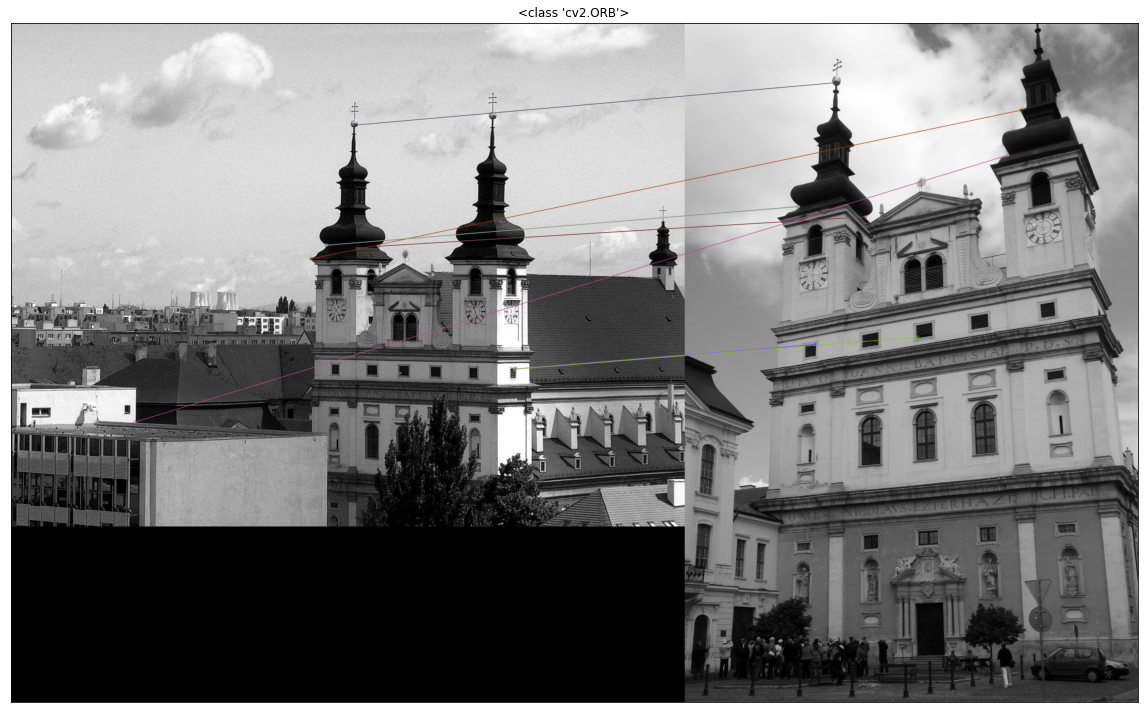

In [19]:
orb = cv2.ORB_create()
draw_image_matches(orb, 'building_1.jpeg', 'building_2.jpeg')

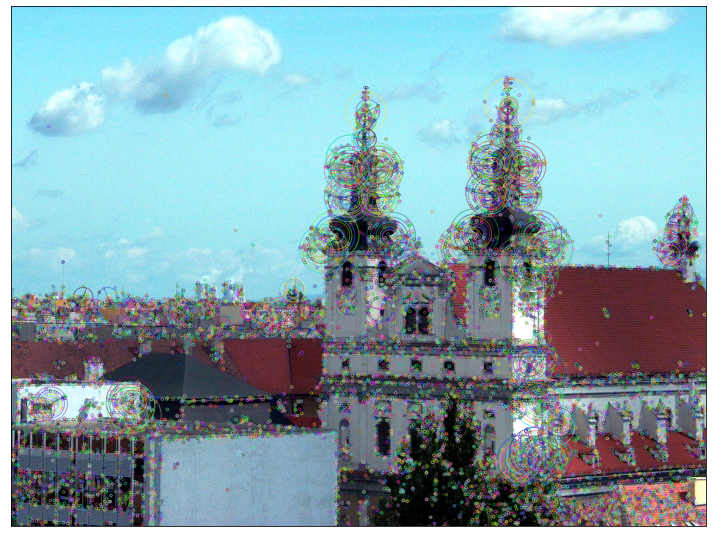

In [20]:
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(img_1, None)
img_kp = cv2.drawKeypoints(img_1, kp, img_1)

plt.figure(figsize=(10, 10))
plt.imshow(img_kp)
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show();

In [21]:
img1, kp1, des1 = image_detect_and_compute(sift, 'building_1.jpeg')
img2, kp2, des2 = image_detect_and_compute(sift, 'building_2.jpeg')

In [22]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

In [23]:
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1, des2, k=2)

In [24]:
matchesMask = [[0, 0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < 0.55*n.distance:
        matchesMask[i] = [1, 0]

draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask,
                   flags=0)

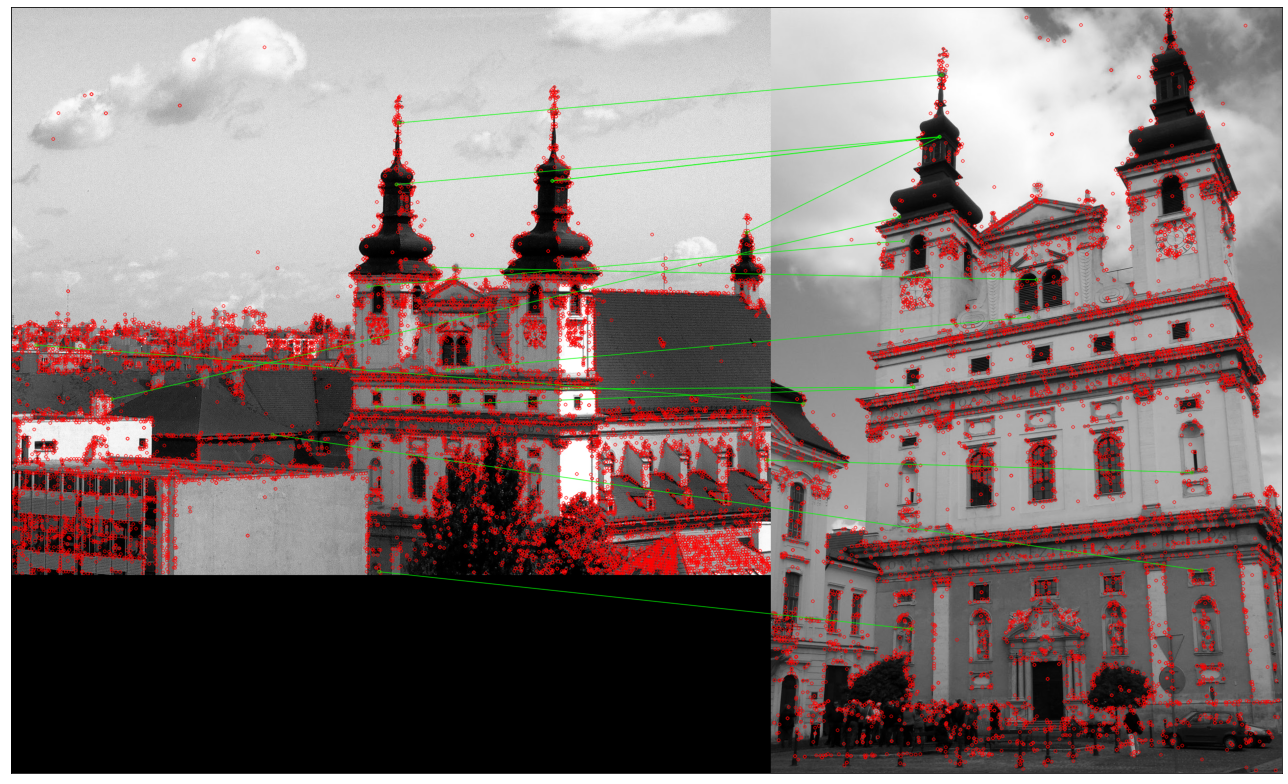

In [25]:
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)
plt.figure(figsize=(18, 18))
plt.imshow(img3)
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show();